In [37]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
spark = SparkSession.builder.appName("Dynamic Price Optimization").getOrCreate()

## Data Collection

In [12]:
data = spark.read.csv('train.csv', sep='|', header=True, inferSchema=True)
df=pd.read_csv('train.csv',delimiter='|')
data.show()

+------+---+-----+------+------------+---------------+-----+------+-----+-----+-------+
|lineID|day|  pid|adFlag|availability|competitorPrice|click|basket|order|price|revenue|
+------+---+-----+------+------------+---------------+-----+------+-----+-----+-------+
|     1|  1| 6570|     0|           2|           14.6|    1|     0|    0|16.89|    0.0|
|     2|  1|14922|     1|           1|           8.57|    0|     1|    0| 8.75|    0.0|
|     3|  1|16382|     0|           1|          14.77|    0|     1|    0|16.06|    0.0|
|     4|  1| 1145|     1|           1|           6.59|    0|     0|    1| 6.55|   6.55|
|     5|  1| 3394|     0|           1|           4.39|    0|     0|    1| 4.14|   4.14|
|     6|  1| 3661|     0|           1|          13.66|    0|     0|    1|10.03|  10.03|
|     7|  1| 3856|     1|           1|           3.03|    0|     0|    1| 3.58|   3.58|
|     8|  1|16963|     0|           1|           8.78|    1|     0|    0| 8.75|    0.0|
|     9|  1|14560|     0|       

## Data Preprocessing

In [13]:
data.printSchema()

root
 |-- lineID: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- pid: integer (nullable = true)
 |-- adFlag: integer (nullable = true)
 |-- availability: integer (nullable = true)
 |-- competitorPrice: double (nullable = true)
 |-- click: integer (nullable = true)
 |-- basket: integer (nullable = true)
 |-- order: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- revenue: double (nullable = true)



In [14]:
data.describe().show()

+-------+-----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+
|summary|           lineID|              day|               pid|             adFlag|       availability|   competitorPrice|             click|             basket|              order|             price|           revenue|
+-------+-----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+
|  count|          2756003|          2756003|           2756003|            2756003|            2756003|           2655316|           2756003|            2756003|            2756003|           2756003|           2756003|
|   mean|        1378002.0| 49.9211789682377|10447.897678630974|0.31778884130387375| 1.1110347122263655| 12.77287958

In [15]:
null_counts = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
null_counts.show()

+------+---+---+------+------------+---------------+-----+------+-----+-----+-------+
|lineID|day|pid|adFlag|availability|competitorPrice|click|basket|order|price|revenue|
+------+---+---+------+------------+---------------+-----+------+-----+-----+-------+
|     0|  0|  0|     0|           0|         100687|    0|     0|    0|    0|      0|
+------+---+---+------+------------+---------------+-----+------+-----+-----+-------+



In [16]:
feature_columns = ["day", "pid", "adFlag", "availability", "competitorPrice", "click", "basket", "order"]
data = data.na.drop(subset=feature_columns)

## Exploratory Data Analysis

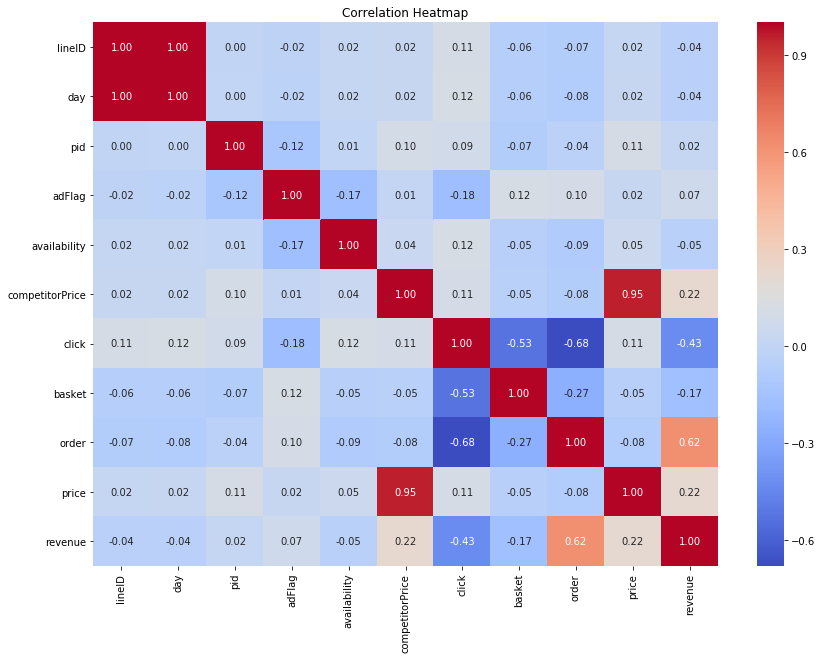

In [8]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

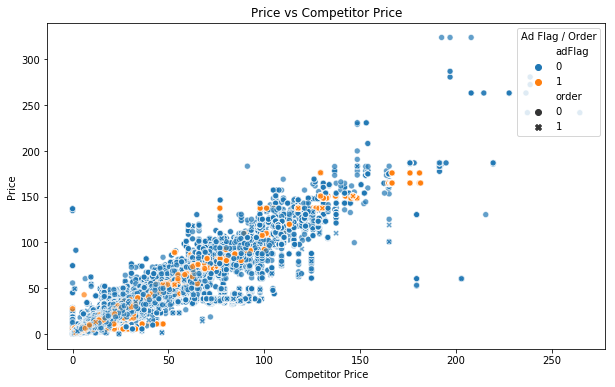

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='competitorPrice', y='price', hue='adFlag', style='order', alpha=0.7)
plt.title("Price vs Competitor Price")
plt.xlabel("Competitor Price")
plt.ylabel("Price")
plt.legend(title='Ad Flag / Order', loc='upper right')
plt.show()

/home/lplab/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


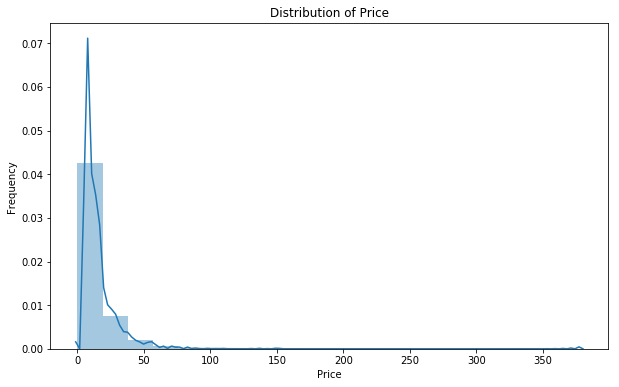

In [46]:
plt.figure(figsize=(10, 6))
sns.distplot(df['price'], bins=20, kde=True)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

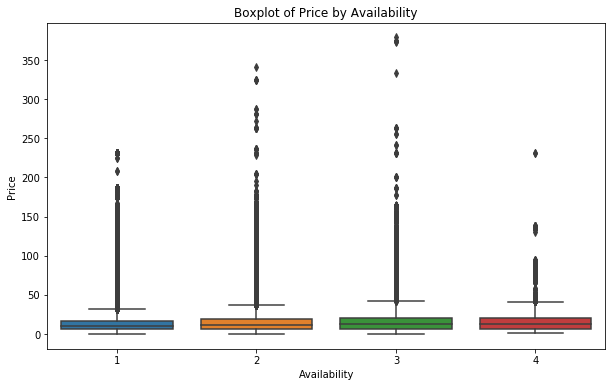

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='availability', y='price')
plt.title("Boxplot of Price by Availability")
plt.xlabel("Availability")
plt.ylabel("Price")
plt.show()

In [17]:
vector_col = "corr_features"
assembler_corr = VectorAssembler(inputCols=feature_columns, outputCol=vector_col)
vector_data = assembler_corr.transform(data)
correlation_matrix = Correlation.corr(vector_data, vector_col).head()[0]
print("Correlation matrix:\n", correlation_matrix)

Correlation matrix:
 DenseMatrix([[ 1.00000000e+00,  5.02007876e-03, -2.40662822e-02,
               2.10493556e-02,  2.39575362e-02,  1.16749960e-01,
              -6.33350506e-02, -7.74180133e-02],
             [ 5.02007876e-03,  1.00000000e+00, -1.18575036e-01,
               6.78976454e-04,  9.67898837e-02,  8.39943327e-02,
              -7.26767660e-02, -3.23708207e-02],
             [-2.40662822e-02, -1.18575036e-01,  1.00000000e+00,
              -1.73379555e-01,  9.94556752e-03, -1.77419152e-01,
               1.15170294e-01,  1.01366721e-01],
             [ 2.10493556e-02,  6.78976454e-04, -1.73379555e-01,
               1.00000000e+00,  3.64228462e-02,  1.18406946e-01,
              -5.35196113e-02, -8.77354644e-02],
             [ 2.39575362e-02,  9.67898837e-02,  9.94556752e-03,
               3.64228462e-02,  1.00000000e+00,  1.05058281e-01,
              -4.92976471e-02, -7.62858531e-02],
             [ 1.16749960e-01,  8.39943327e-02, -1.77419152e-01,
               1.18

# Predictive Analysis

In [18]:
data = data.withColumn("adFlag", col("adFlag").cast("double"))
assembler = VectorAssembler(inputCols=["day", "pid", "adFlag", "availability", "competitorPrice", "click", "basket"], outputCol="features")
data = assembler.transform(data)

In [19]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

## 1. Linear Regression

In [20]:
lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
print("Linear Regression RMSE:", lr_evaluator.evaluate(lr_predictions))

Linear Regression RMSE: 3.912977489170398


## 2. Random Forest

In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol="features", labelCol="order")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

rf_evaluator = MulticlassClassificationEvaluator(labelCol="order", predictionCol="prediction", metricName="accuracy")
print("Random Forest Accuracy:", rf_evaluator.evaluate(rf_predictions))

Random Forest Accuracy: 1.0


## 3. K-Means Clustering

In [24]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

In [26]:
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(data)
    inertia.append(model.summary.trainingCost)

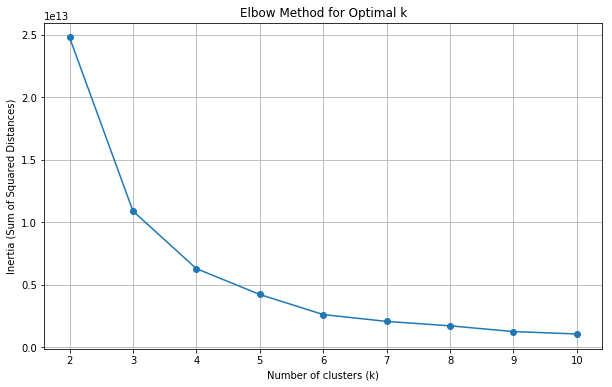

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.xticks(k_values)
plt.grid()
plt.show()

In [28]:
optimal_k = 3  
kmeans = KMeans(k=optimal_k, seed=1)
kmeans_model = kmeans.fit(data)
predictions = kmeans_model.transform(data)

In [29]:
predictions.select("features", "scaled_features", "prediction").show()

+--------------------+--------------------+----------+
|            features|     scaled_features|prediction|
+--------------------+--------------------+----------+
|[1.0,6570.0,0.0,2...|[-1.9334794249093...|         1|
|[1.0,14922.0,1.0,...|[-1.9334794249093...|         2|
|[1.0,16382.0,0.0,...|[-1.9334794249093...|         2|
|[1.0,1145.0,1.0,1...|[-1.9334794249093...|         1|
|[1.0,3394.0,0.0,1...|[-1.9334794249093...|         1|
|[1.0,3661.0,0.0,1...|[-1.9334794249093...|         1|
|[1.0,3856.0,1.0,1...|[-1.9334794249093...|         1|
|[1.0,16963.0,0.0,...|[-1.9334794249093...|         2|
|[1.0,14560.0,0.0,...|[-1.9334794249093...|         2|
|[1.0,4853.0,1.0,1...|[-1.9334794249093...|         1|
|[1.0,14921.0,1.0,...|[-1.9334794249093...|         2|
|[1.0,4055.0,1.0,1...|[-1.9334794249093...|         1|
|[1.0,14010.0,0.0,...|[-1.9334794249093...|         0|
|[1.0,18558.0,0.0,...|[-1.9334794249093...|         2|
|[1.0,5567.0,1.0,1...|[-1.9334794249093...|         1|
|[1.0,1315

In [44]:
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x='scaled_features', y='scaled_features', hue='prediction', palette='viridis', alpha=0.6)
# plt.title("K-Means Clustering Results")
# plt.xlabel("Feature 1 (scaled)")
# plt.ylabel("Feature 2 (scaled)")
# plt.legend(title='Cluster')
# plt.show()

In [33]:
def monte_carlo_simulation(data, num_simulations=50):
    results = []
    
    for _ in range(num_simulations):
        sampled_prices = np.random.choice(data['price'], size=len(data), replace=True)
        adjusted_prices = sampled_prices + np.random.normal(0, 1, size=len(sampled_prices))
        
        expected_revenue = np.sum(adjusted_prices * data['order'])
        results.append(expected_revenue)
    
    return results

In [40]:
simulation_results = monte_carlo_simulation(df)

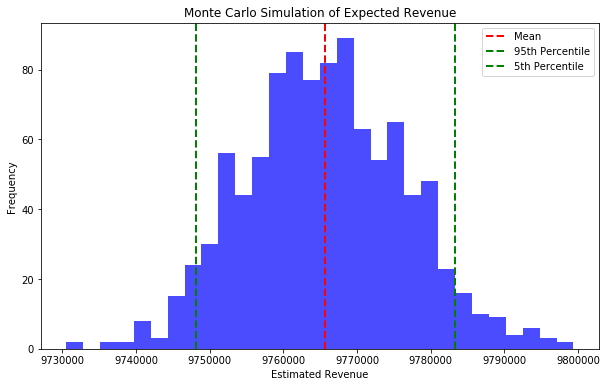

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(simulation_results, bins=30, color='blue', alpha=0.7)
plt.title("Monte Carlo Simulation of Expected Revenue")
plt.xlabel("Estimated Revenue")
plt.ylabel("Frequency")
plt.axvline(np.mean(simulation_results), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(simulation_results, 95), color='green', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(simulation_results, 5), color='green', linestyle='dashed', linewidth=2)
plt.legend({"Mean": np.mean(simulation_results), "95th Percentile": np.percentile(simulation_results, 95), "5th Percentile": np.percentile(simulation_results, 5)})
plt.show()

In [42]:
mean_revenue = np.mean(simulation_results)
conf_interval_95 = np.percentile(simulation_results, [5, 95])
print(f"Estimated Mean Revenue: {mean_revenue:.2f}")
print(f"95% Confidence Interval: {conf_interval_95}")

Estimated Mean Revenue: 9765674.70
95% Confidence Interval: [9748170.74009478 9783250.49812646]
